In [1]:
.libPaths(Sys.getenv('R_LIBS_USER'))
NUM_THREADS = 48

In [2]:
library(data.table)
library(stringr)
library(parallel)
library(magrittr)
library(ggplot2)

In [3]:
setDTthreads(NUM_THREADS)

In [4]:
setwd('/scratch/saberi/isoseq/RTOpt')

In [5]:
s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

types = c('fl', 'flnc', 'clustered.hq')
steps = c('raw', 'aligned', 'aligned.hq')

In [6]:
.get_read_stats = function(sn, type, step) {
    
    if(step == 'raw') file_name = str_glue('samples/{sn}/{sn}.{type}.tsv')
    if(step == 'aligned') file_name = str_glue('samples/{sn}/{sn}.{type}.aln-gene.mm2.splice-hq.sorted.tsv')
    if(step == 'aligned.hq') file_name = str_glue('samples/{sn}/{sn}.{type}.aln-gene.mm2.splice-hq.sorted.filtered.tsv')
    
    read_stats = fread(file_name, select = c(1, 3), col.names = c('qname', 'len'))
    read_stats[, sample := sn]
    read_stats[, type := str_to_upper(type)]
    read_stats[, step := str_to_upper(step)]
    
    if(type %like% 'clustered') {
        cluster_info_file = str_glue('samples/{sn}/{sn}.clustered.cluster_report.csv', select = 2)
        cluster_info = fread(cluster_info_file)
        cluster_info = cluster_info[, .N, cluster_id]

        read_stats = merge(read_stats, cluster_info, by.x = 'qname', by.y = 'cluster_id')

        read_stats = merge(read_stats,
                        read_stats[, .(index = seq(N)), qname],
                        by = 'qname')
        
        read_stats = read_stats[, .(qname, len, sample, type, step)]
    }
    
    read_stats
}

In [7]:
read_stats = 
    lapply(sample_names, function(sn) {
        lapply(types, function(type) {
            lapply(steps, function(step) {
                .get_read_stats(sn, type, step)
            })
        })
    })

In [8]:
read_stats = read_stats %>% unlist(recursive = F) %>% unlist(recursive = F)

In [9]:
read_stats_all = Reduce(rbind, read_stats)

In [10]:
read_stats_all[, type_step := str_c(type, step, sep = '_')]

In [11]:
type_step_levels = types %>% str_to_upper %>% rep(each = length(steps)) %>%
    str_c(steps %>% str_to_upper, sep = '_')

In [12]:
read_stats_all[, type_step := factor(type_step,
                                    levels = type_step_levels,
                                    ordered = T)]

In [19]:
read_stats_plot = ggplot(read_stats_all) +
    aes(x = sample, y = len, fill = type_step) +
    geom_boxplot(alpha = 0.25, outlier.shape = NA) +
    theme_minimal() +
    theme(text=element_text(size=15),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = 'PacBio IsoSeq Reads Length per Sample') +
    xlab('Sample') +
    scale_y_continuous(name = 'Reads Length', limits = c(0, 6e3), breaks = seq(0, 6e3, 0.5e3)) +
    scale_fill_manual(values =
                      c('firebrick1',
                        'firebrick3',
                        'firebrick4',
                        'gold1',
                        'goldenrod2',
                        'goldenrod4',
                        'darkolivegreen1',
                        'darkolivegreen3',
                        'darkolivegreen4'))

In [20]:
ggsave(read_stats_plot, device = 'pdf', file = 'plots/read_len_all_v2.pdf', width = 20, height = 5)

Warning message:
“Removed 26729 rows containing non-finite values (stat_boxplot).”


In [24]:
libsize_all_plot = ggplot(read_stats_all[, .N, .(sample, type_step)]) +
    aes(x = sample, y = N, fill = type_step) +
    geom_bar(position='dodge', stat='identity', alpha = 0.75) +
    theme_minimal() +
    theme(text=element_text(size=15)) + 
    labs(title = 'PacBio IsoSeq Library Size per Sample') +
    scale_y_continuous(name = 'Library Size', limits = c(0, 7e5), breaks = seq(0, 7e5, 0.5e5)) +
    scale_fill_manual(values =
                      c('firebrick1',
                        'firebrick3',
                        'firebrick4',
                        'gold1',
                        'goldenrod2',
                        'goldenrod4',
                        'darkolivegreen1',
                        'darkolivegreen3',
                        'darkolivegreen4'))

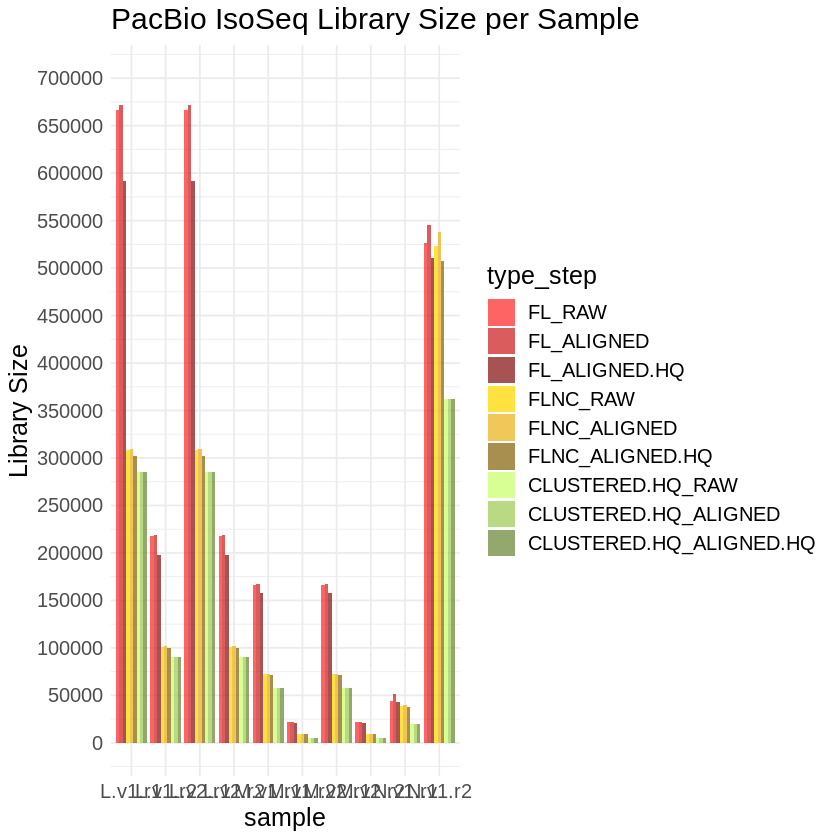

In [25]:
libsize_all_plot

In [26]:
ggsave(libsize_all_plot, device = 'pdf', file = 'plots/libsize_all_v2.pdf', width = 20, height = 5)

# SQANTI3 Results

In [225]:
.get_sqanti_results = function(sn, type) {
    
    if(type == 'fl') desc = 'RAW'
    if(type == 'flnc') desc = 'REFINED'
    
    sqanti_result_file = str_glue('samples/{sn}/SQANTI3/{sn}.{type}.transcriptome.sqanti3_classification.txt')

    sqanti = fread(sqanti_result_file)

    num_tr_cat = sqanti[, .N, structural_category]
    setnames(num_tr_cat, 'structural_category', 'feature')

    sqanti[!(associated_gene %like% 'ENS'), novel_gene := associated_gene %>% str_remove('_[0-9]*$')]
    num_known_genes = sqanti[associated_gene %like% 'ENS', associated_gene %>% unique %>% length]
    num_novel_genes = sqanti[, novel_gene %>% na.omit %>% unique %>% length]
    num_known_trs = sqanti[associated_transcript %like% 'ENS', associated_transcript %>% unique %>% length]
    num_novel_trs = sqanti[associated_transcript %like% 'novel', associated_transcript %>% length]
    num_genes_df = data.table(feature = c('num_known_genes', 'num_novel_genes', 'num_known_trs', 'num_novel_trs'),
                              N = c(num_known_genes, num_novel_genes, num_known_trs, num_novel_trs))

    num_df = rbind(num_genes_df, num_tr_cat)
    num_df[, sample := sn]
    num_df[, type := str_to_upper(type)]
    num_df[, desc := desc]
    setcolorder(num_df, c('sample', 'type', 'desc'))
    
    num_df
}

In [226]:
num_df = .get_sqanti_results('L.v1.r1', 'fl')

In [227]:
s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

types = c('fl', 'flnc')

In [228]:
sqanti = 
    lapply(sample_names, function(sn) {
        lapply(types, function(type) {
            .get_sqanti_results(sn, type)
        })
    })

In [229]:
sqanti = sqanti %>% unlist(recursive = F)

In [230]:
sqanti_all = Reduce(rbind, sqanti)

In [231]:
sqanti_all_cat = sqanti_all[!(feature %like% 'num_')]
sqanti_all_num = sqanti_all[feature %like% 'num_']

### SQANTI CAT

In [232]:
sqanti_all_cat[, feature := factor(feature,
                                  levels = c('full-splice_match',
                                             'incomplete-splice_match',
                                             'novel_in_catalog',
                                             'novel_not_in_catalog',
                                             'genic',
                                             'intergenic',
                                             'antisense',
                                             'fusion'),
                                   ordered = T)]
sqanti_all_cat[, desc := factor(desc,
                                levels = c('RAW', 'REFINED'),
                                ordered = T)]

In [233]:
sqanti_cat_plot = ggplot(sqanti_all_cat) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='dodge2', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Isoform Category per Sample (Dodge)')  +
    scale_y_continuous(name = 'Count', limits = c(0, 3e3), breaks = seq(0, 3e3, 1e2)) +
    xlab('Sample')

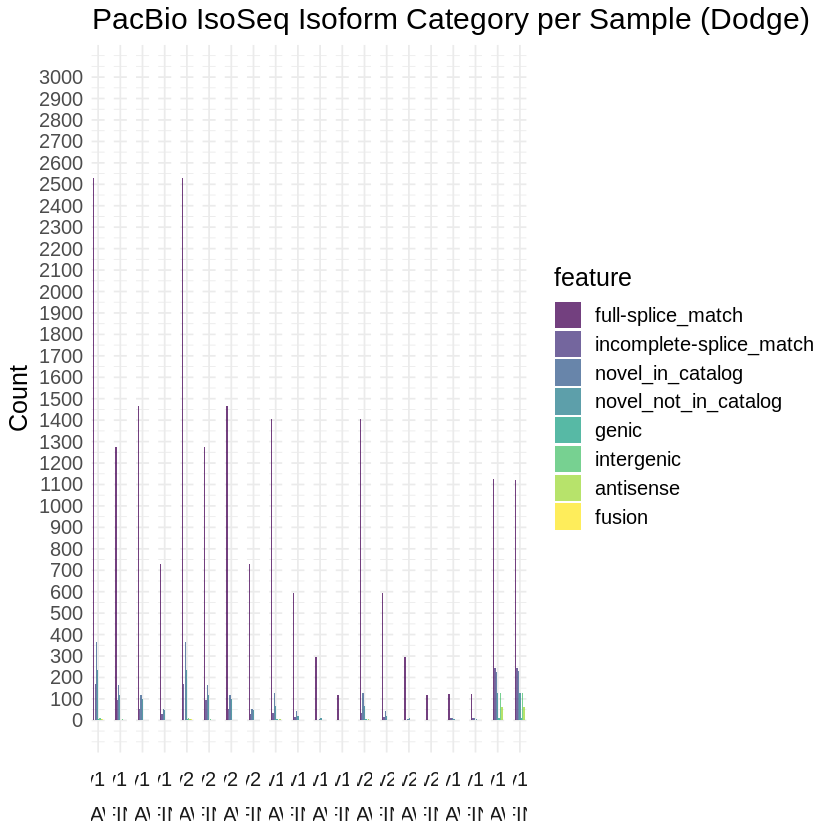

In [234]:
sqanti_cat_plot

In [235]:
ggsave(sqanti_cat_plot, device = 'pdf', file = 'plots/sqanti_category_dodge.pdf', width = 20, height = 7.5)

In [236]:
sqanti_cat_plot = ggplot(sqanti_all_cat) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='stack', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Isoform Category per Sample (Stacked)')  +
    scale_y_continuous(name = 'Count', limits = c(0, 3.5e3), breaks = seq(0, 3.5e3, 1e2)) +
    xlab('Sample')

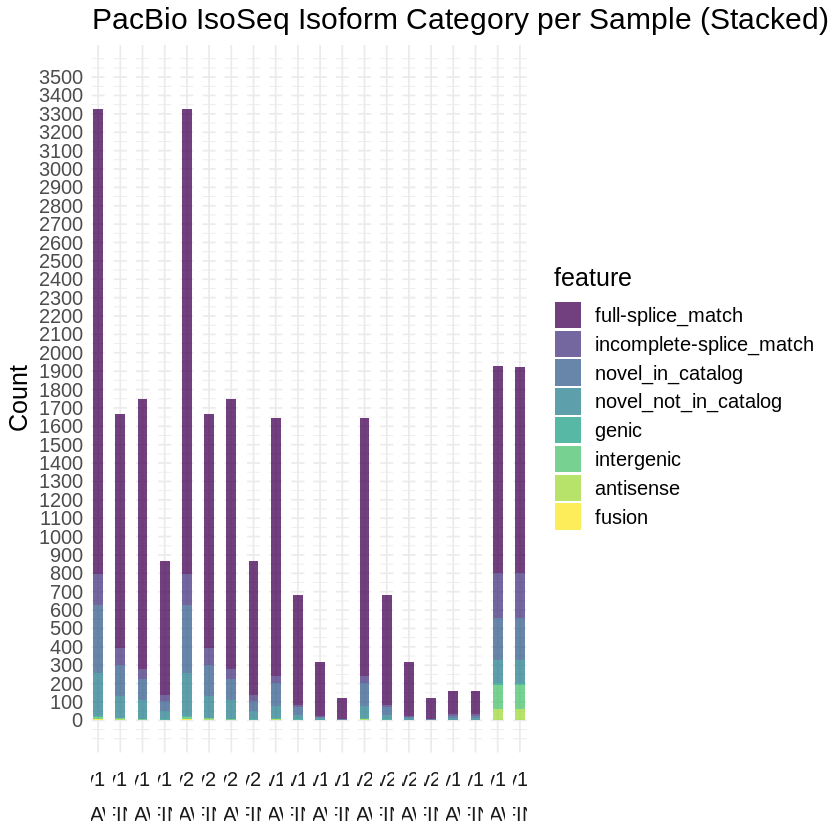

In [237]:
sqanti_cat_plot

In [238]:
ggsave(sqanti_cat_plot, device = 'pdf', file = 'plots/sqanti_category_stacked.pdf', width = 20, height = 8)

---

### SQANTI NUM

In [239]:
sqanti_all_num[, feature := factor(feature,
                                  levels = c('num_known_genes',
                                             'num_novel_genes',
                                             'num_known_trs',
                                             'num_novel_trs'),
                                   ordered = T)]
sqanti_all_num[, desc := factor(desc,
                                levels = c('RAW', 'REFINED'),
                                ordered = T)]

In [240]:
sqanti_num_plot = ggplot(sqanti_all_num) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='dodge2', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Genes and Transcripts Category per Sample (Dodge)')  +
    scale_y_continuous(name = 'Count', limits = c(0, 2.5e3), breaks = seq(0, 2.5e3, 1e2)) +
    xlab('Sample')

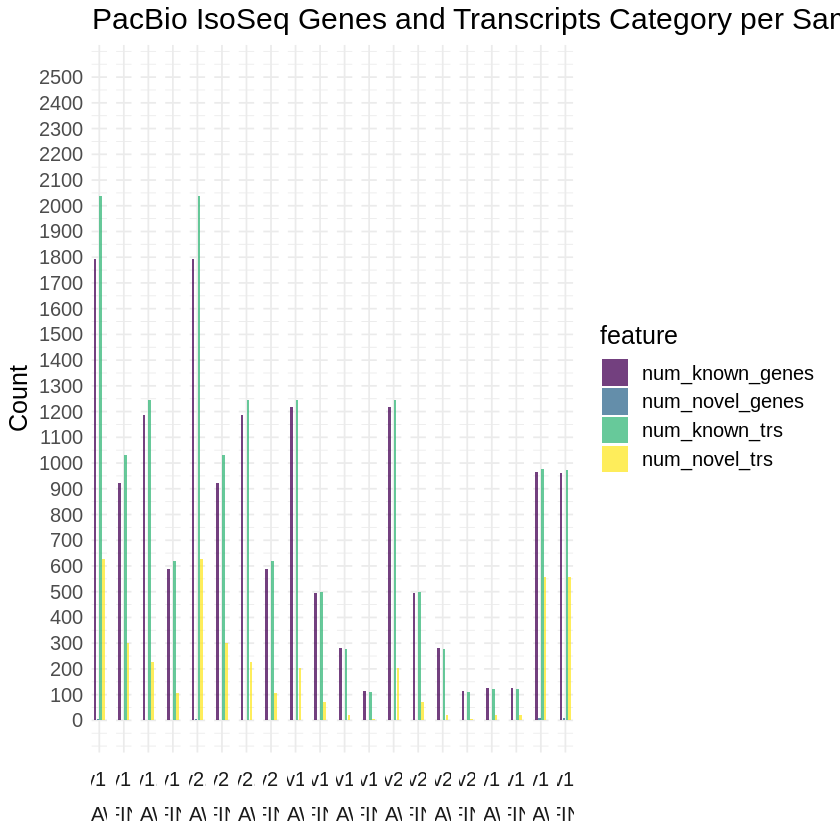

In [241]:
sqanti_num_plot

In [242]:
ggsave(sqanti_num_plot, device = 'pdf', file = 'plots/sqanti_num_dodge.pdf', width = 20, height = 7.5)

In [243]:
sqanti_all_num[feature %like% 'gene', type := 'GENE']
sqanti_all_num[feature %like% 'tr', type := 'TR']

In [244]:
sqanti_num_plot = ggplot(sqanti_all_num) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='stack', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc + type, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Genes and Transcripts Category per Sample (Stacked)')  +
    scale_y_continuous(name = 'Count', limits = c(0, 3e3), breaks = seq(0, 3e3, 1e2)) +
    xlab('Sample')

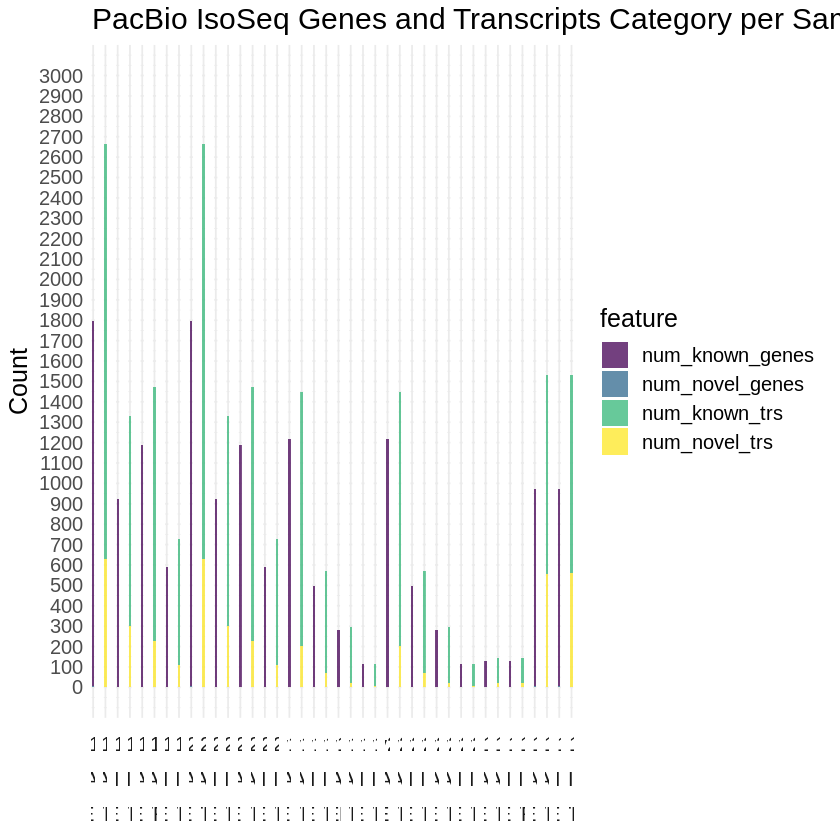

In [245]:
sqanti_num_plot

In [ ]:
ggsave(sqanti_num_plot, device = 'pdf', file = 'plots/sqanti_num_stacked.pdf', width = 35, height = 10)

---

## SQANTI Metrics Normalized by Library Size

In [296]:
.get_sqanti_results = function(sn, type) {
    
    if(type == 'fl') desc = 'RAW'
    if(type == 'flnc') desc = 'REFINED'
    
    sqanti_result_file = str_glue('samples/{sn}/SQANTI3/{sn}.{type}.transcriptome.sqanti3_classification.txt')

    sqanti = fread(sqanti_result_file)

    num_tr_cat = sqanti[, .N, structural_category]
    setnames(num_tr_cat, 'structural_category', 'feature')

    sqanti[!(associated_gene %like% 'ENS'), novel_gene := associated_gene %>% str_remove('_[0-9]*$')]
    num_known_genes = sqanti[associated_gene %like% 'ENS', associated_gene %>% unique %>% length]
    num_novel_genes = sqanti[, novel_gene %>% na.omit %>% unique %>% length]
    num_known_trs = sqanti[associated_transcript %like% 'ENS', associated_transcript %>% unique %>% length]
    num_novel_trs = sqanti[associated_transcript %like% 'novel', associated_transcript %>% length]
    num_genes_df = data.table(feature = c('num_known_genes', 'num_novel_genes', 'num_known_trs', 'num_novel_trs'),
                              N = c(num_known_genes, num_novel_genes, num_known_trs, num_novel_trs))

    num_df = rbind(num_genes_df, num_tr_cat)
    num_df[, sample := sn]
    num_df[, type := str_to_upper(type)]
    num_df[, desc := desc]
    setcolorder(num_df, c('sample', 'type', 'desc'))
    
    ### Normalization by Libsize
    qname_file = str_glue('samples/{sn}/{sn}.{type}.clustered.hq.qname.list')
    qname = fread(qname_file, header = F, col.names = 'qname')
    libsize = nrow(qname)
    
    num_df[, N := (N / libsize) * 1e6]
    
    num_df
}

In [297]:
s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

types = c('fl', 'flnc')

In [298]:
sqanti = 
    lapply(sample_names, function(sn) {
        lapply(types, function(type) {
            .get_sqanti_results(sn, type)
        })
    })

In [299]:
sqanti = sqanti %>% unlist(recursive = F)

In [300]:
sqanti_all = Reduce(rbind, sqanti)

In [301]:
sqanti_all_cat = sqanti_all[!(feature %like% 'num_')]
sqanti_all_num = sqanti_all[feature %like% 'num_']

### SQANTI CAT

In [302]:
sqanti_all_cat[, feature := factor(feature,
                                  levels = c('full-splice_match',
                                             'incomplete-splice_match',
                                             'novel_in_catalog',
                                             'novel_not_in_catalog',
                                             'genic',
                                             'intergenic',
                                             'antisense',
                                             'fusion'),
                                   ordered = T)]
sqanti_all_cat[, desc := factor(desc,
                                levels = c('RAW', 'REFINED'),
                                ordered = T)]

In [310]:
sqanti_all_cat[, summary(N)]

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   421.2   1874.0  17535.8  86279.6  39366.5 780423.3 

In [316]:
sqanti_cat_plot = ggplot(sqanti_all_cat) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='dodge2', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Isoform Category per Sample (Dodge). Normalized.')  +
    scale_y_continuous(name = 'Count / LibSize * 1e6', limits = c(0, 1e6), breaks = seq(0, 1e6, 2.5e4)) +
    xlab('Sample')

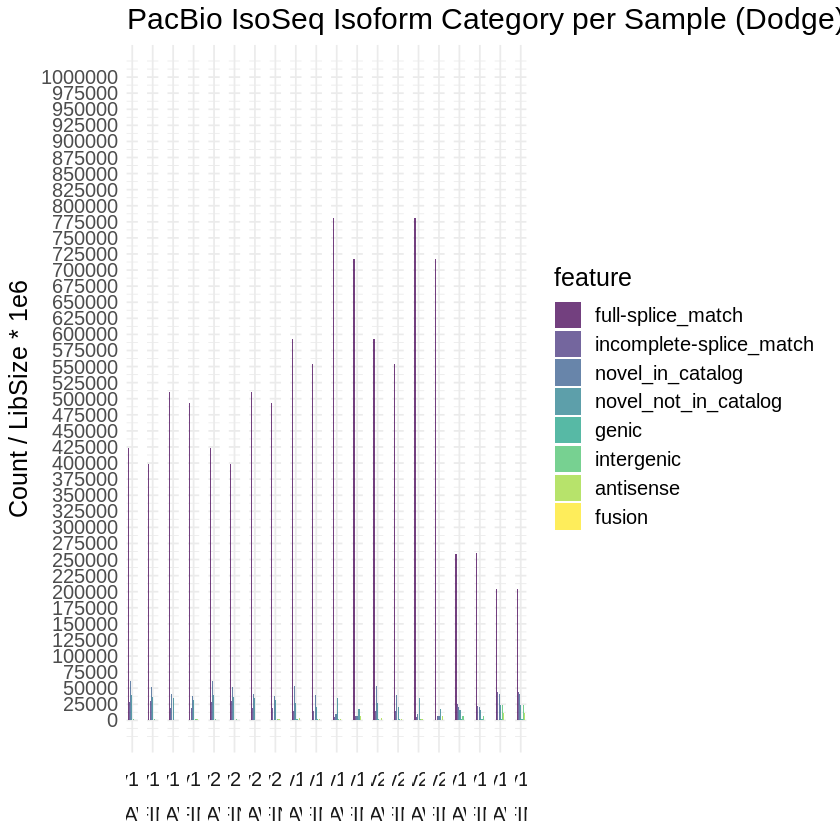

In [317]:
sqanti_cat_plot

In [318]:
ggsave(sqanti_cat_plot, device = 'pdf', file = 'plots/sqanti_category_normed_dodge.pdf', width = 20, height = 7.5)

In [319]:
sqanti_cat_plot = ggplot(sqanti_all_cat) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='stack', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Isoform Category per Sample (Stacked). Normalized')  +
    scale_y_continuous(name = 'Count / LibSize * 1e6', limits = c(0, 1e6), breaks = seq(0, 1e6, 2.5e4)) +
    xlab('Sample')

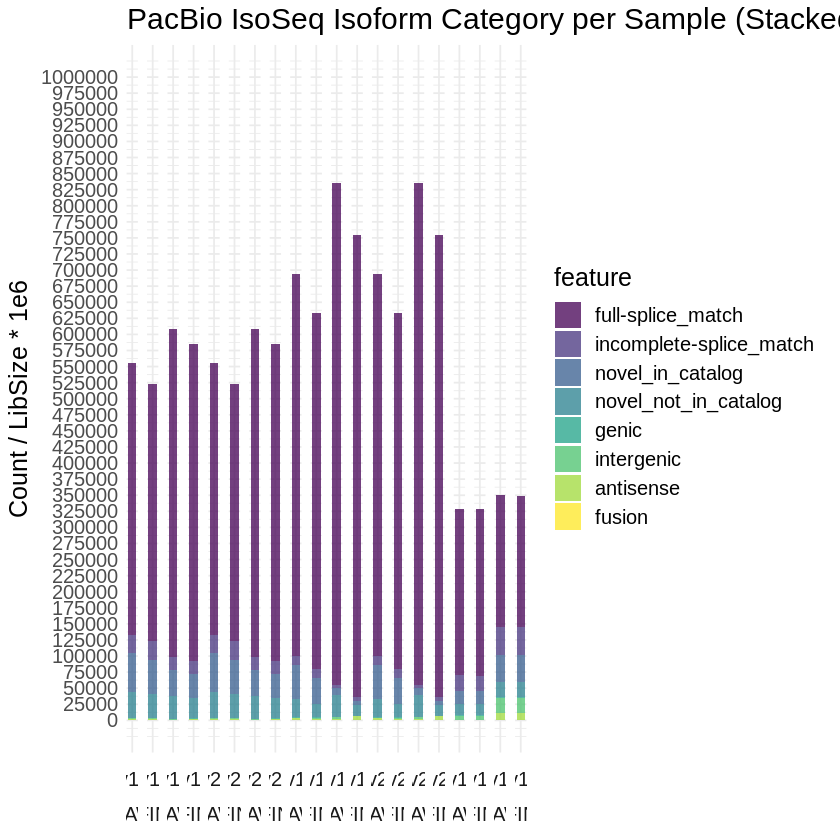

In [320]:
sqanti_cat_plot

In [321]:
ggsave(sqanti_cat_plot, device = 'pdf', file = 'plots/sqanti_category_normed_stacked.pdf', width = 20, height = 8)

---

### SQANTI NUM

In [323]:
sqanti_all_num[, feature := factor(feature,
                                  levels = c('num_known_genes',
                                             'num_novel_genes',
                                             'num_known_trs',
                                             'num_novel_trs'),
                                   ordered = T)]
sqanti_all_num[, desc := factor(desc,
                                levels = c('RAW', 'REFINED'),
                                ordered = T)]

In [324]:
sqanti_num_plot = ggplot(sqanti_all_num) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='dodge2', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Genes and Transcripts Category per Sample (Dodge). Normalized.')  +
    scale_y_continuous(name = 'Count / LibSize * 1e6', limits = c(0, 1e6), breaks = seq(0, 1e6, 2.5e4)) +
    xlab('Sample')

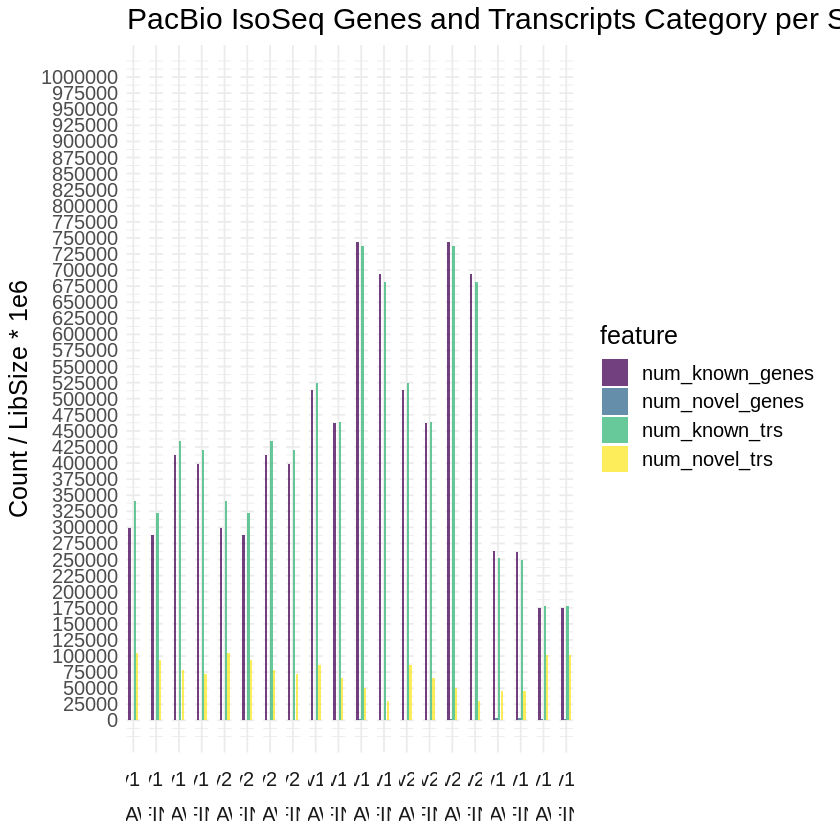

In [325]:
sqanti_num_plot

In [326]:
ggsave(sqanti_num_plot, device = 'pdf', file = 'plots/sqanti_num_normed_dodge.pdf', width = 20, height = 7.5)

In [327]:
sqanti_all_num[feature %like% 'gene', type := 'GENE']
sqanti_all_num[feature %like% 'tr', type := 'TR']

In [328]:
sqanti_num_plot = ggplot(sqanti_all_num) +
    aes(x = desc, y = N, fill = feature) +
    geom_bar(position='stack', stat='identity', alpha = 0.75) +
    facet_grid(~sample + desc + type, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Genes and Transcripts Category per Sample (Stacked)')  +
    scale_y_continuous(name = 'Count / LibSize * 1e6', limits = c(0, 1e6), breaks = seq(0, 1e6, 2.5e4)) +
    xlab('Sample')

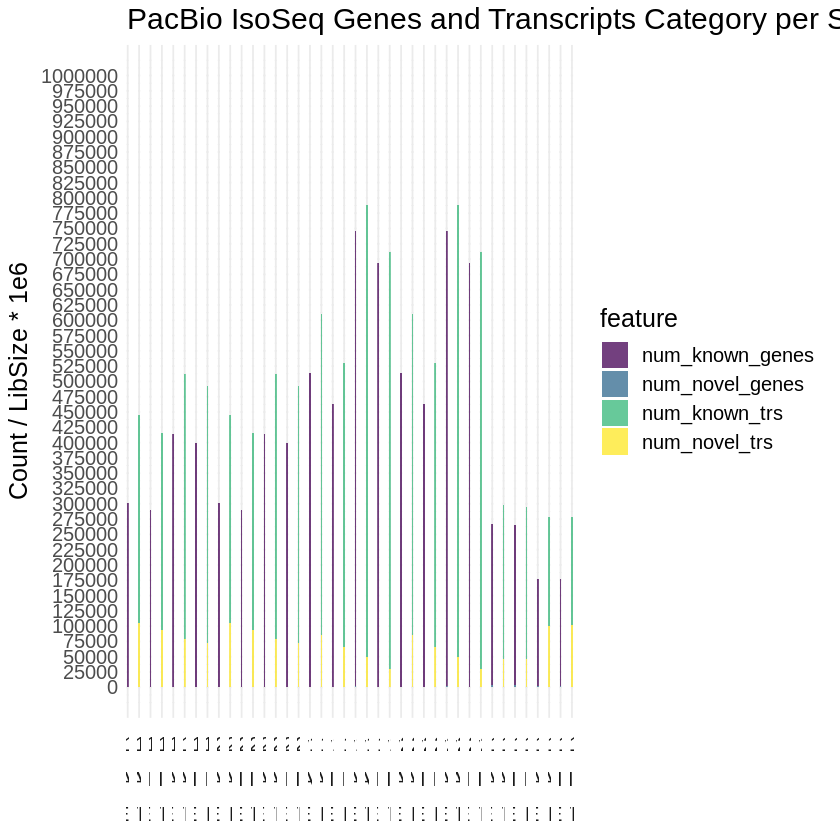

In [329]:
sqanti_num_plot

In [330]:
ggsave(sqanti_num_plot, device = 'pdf', file = 'plots/sqanti_num_normed_stacked.pdf', width = 35, height = 10)

---

## Reads Length of SQANTI Isoforms Categories

In [250]:
.get_sqanti_full_results = function(sn, type) {
    
    if(type == 'fl') desc = 'RAW'
    if(type == 'flnc') desc = 'REFINED'
    
    sqanti_result_file = str_glue('samples/{sn}/SQANTI3/{sn}.{type}.transcriptome.sqanti3_classification.txt')

    sqanti = fread(sqanti_result_file)
    sqanti = sqanti[, .(structural_category, length)]
    setnames(sqanti, 'structural_category', 'feature')
    
    sqanti[, sample := sn]
    sqanti[, type := str_to_upper(type)]
    sqanti[, desc := desc]
    setcolorder(sqanti, c('sample', 'type', 'desc'))
    
    sqanti
    
}

In [251]:
sqanti_df = .get_sqanti_full_results('L.v1.r1', 'fl')

In [254]:
s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

types = c('fl', 'flnc')

In [255]:
sqanti = 
    lapply(sample_names, function(sn) {
        lapply(types, function(type) {
            .get_sqanti_full_results(sn, type)
        })
    })

In [256]:
sqanti = sqanti %>% unlist(recursive = F)

In [257]:
sqanti_all = Reduce(rbind, sqanti)

In [258]:
sqanti_all[, feature := factor(feature,
                                  levels = c('full-splice_match',
                                             'incomplete-splice_match',
                                             'novel_in_catalog',
                                             'novel_not_in_catalog',
                                             'genic',
                                             'intergenic',
                                             'antisense',
                                             'fusion'),
                                   ordered = T)]
sqanti_all[, desc := factor(desc,
                                levels = c('RAW', 'REFINED'),
                                ordered = T)]

In [272]:
read_stats_plot = ggplot(sqanti_all) +
    aes(y = length, fill = feature) +
    geom_boxplot(alpha = 0.25, outlier.shape = NA) +
    facet_grid(~sample + desc + type, scales = "free", switch = "x", space = "free_x") +
    theme_minimal() +
    theme(text=element_text(size=15),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.placement = "outside") + 
    labs(title = 'PacBio IsoSeq Reads Length of Isoform Category Per Sample') +
    xlab('Sample') +
    scale_y_continuous(name = 'Reads Length', limits = c(0, 6e3), breaks = seq(0, 6e3, 0.5e3))

Warning message:
“Removed 63 rows containing non-finite values (stat_boxplot).”


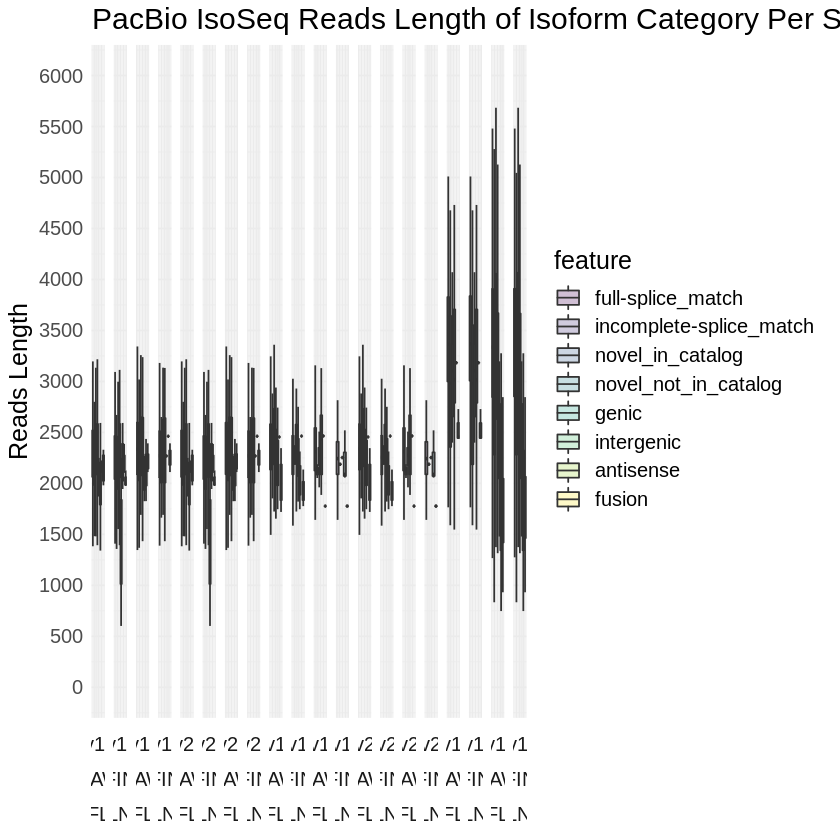

In [273]:
read_stats_plot

In [274]:
ggsave(read_stats_plot, device = 'pdf', file = 'plots/read_len_sqanti_cat.pdf', width = 30, height = 5)

Warning message:
“Removed 63 rows containing non-finite values (stat_boxplot).”
